# Import libraries and setup matplotlib

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('waveglow/')

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd
import pickle as pkl
import librosa
from text import *
import numpy as np
import torch
import hparams
from model import Model
from denoiser import Denoiser

### Text preprocessing

In [2]:
from g2p_en import G2p
from text.symbols import symbols
from text.cleaners import custom_english_cleaners

# Mappings from symbol to numeric ID and vice versa:
symbol_to_id = {s: i for i, s in enumerate(symbols)}
id_to_symbol = {i: s for i, s in enumerate(symbols)}

g2p = G2p()
def text2seq(text, data_type='char'):
    text = custom_english_cleaners(text.rstrip())
    if data_type=='phone':
        clean_phone = []
        for s in g2p(text.lower()):
            if '@'+s in symbol_to_id:
                clean_phone.append('@'+s)
            else:
                clean_phone.append(s)
                text = clean_phone
                
    sequence = [symbol_to_id[c] for c in text]
    # Append EOS token
    sequence.append(symbol_to_id['~'])
    return sequence

### Waveglow

In [3]:
waveglow_path = 'training_log/waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']

for m in waveglow.modules():
    if 'Conv' in str(type(m)):
        setattr(m, 'padding_mode', 'zeros')

waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

with open('filelists/ljs_audio_text_val_filelist.txt', 'r') as f:
    lines = [line.split('|') for line in f.read().splitlines()]

Text: (LJ001-0029)
But though on the whole, except in Italy, Gothic letter was most often used

Melspectrogram: (LJ001-0029)


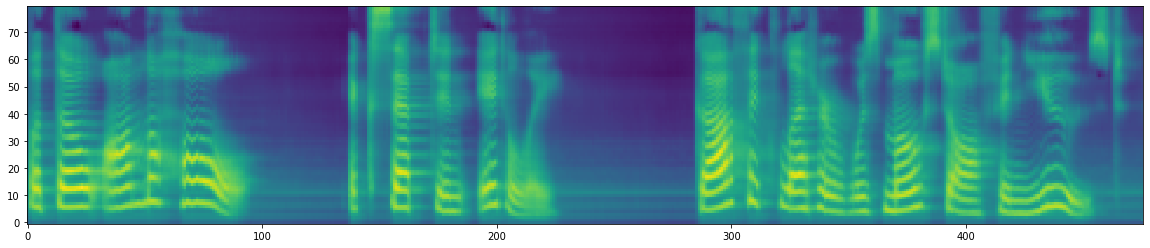

Audio: (LJ001-0029)


Stop: (LJ001-0029)


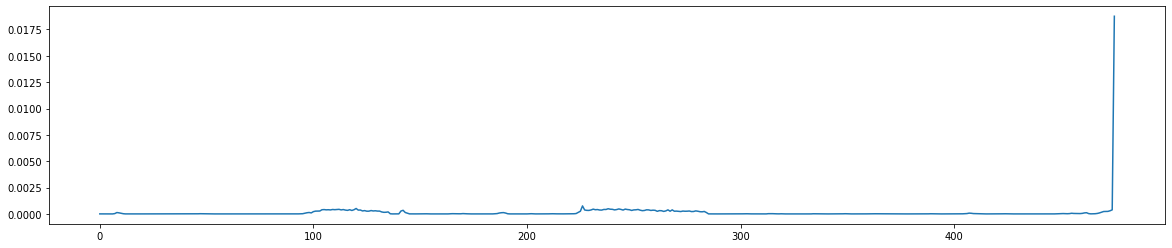

Enc_alignments: (LJ001-0029)


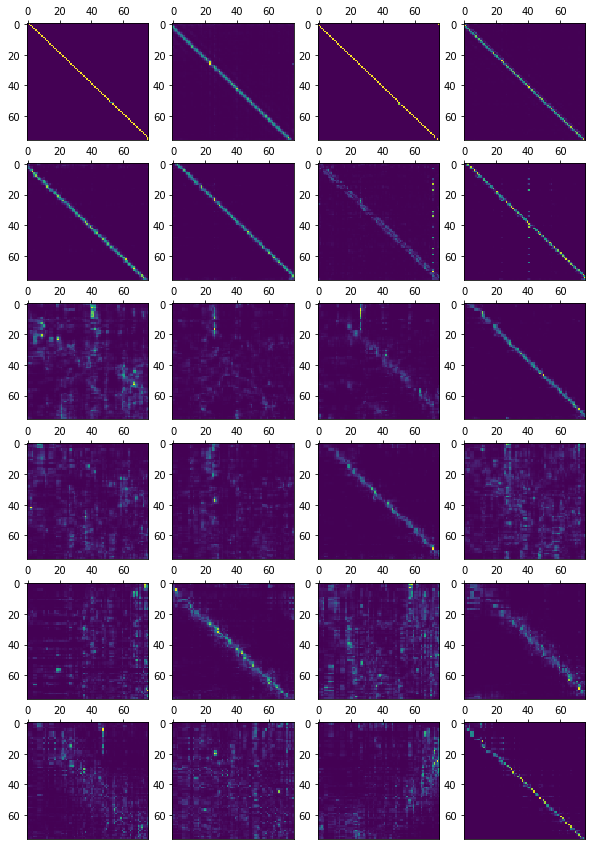

Dec_alignments: (LJ001-0029)


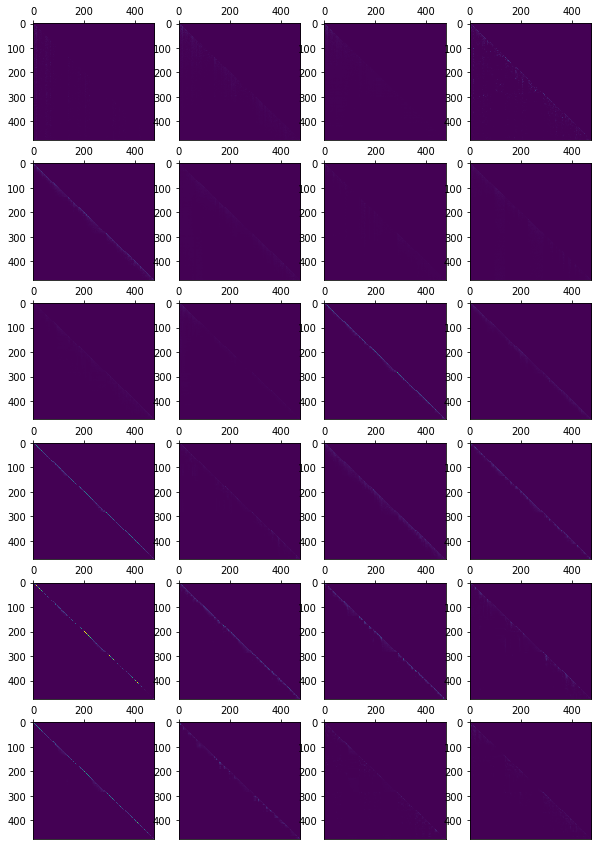

Enc_Dec_alignments: (LJ001-0029)


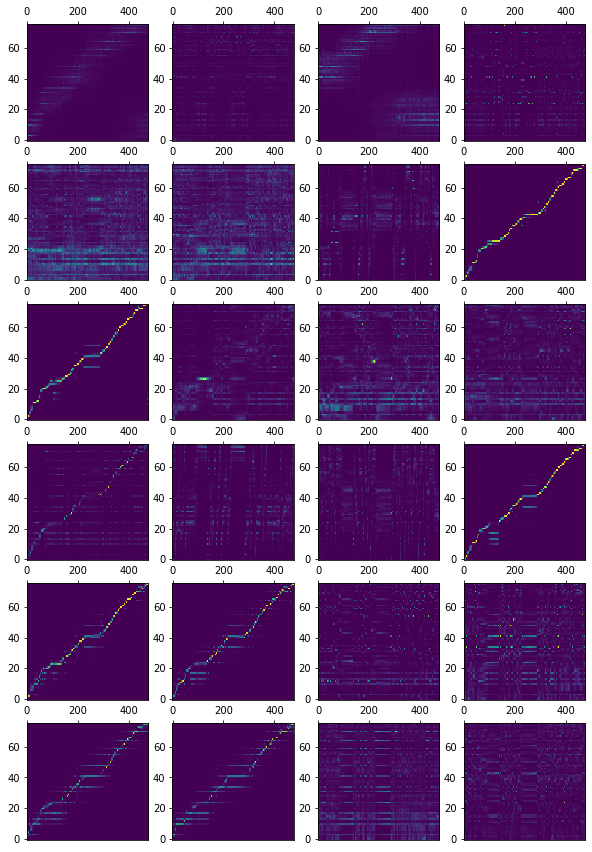

Text: (LJ001-0085)
It was reserved for the founders of the later eighteenth century to produce letters which are positively ugly, and which, it may be added,

Melspectrogram: (LJ001-0085)


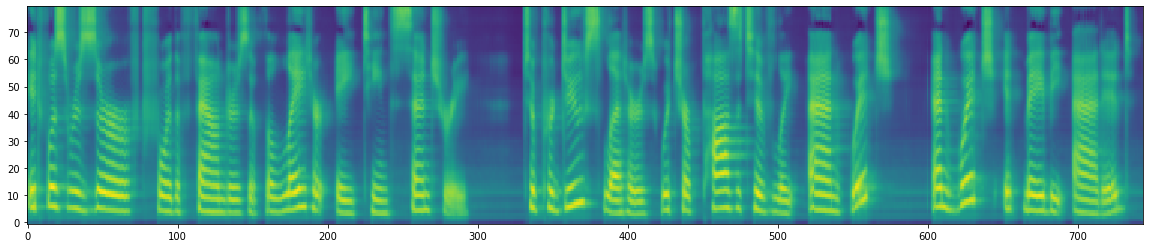

Audio: (LJ001-0085)


Stop: (LJ001-0085)


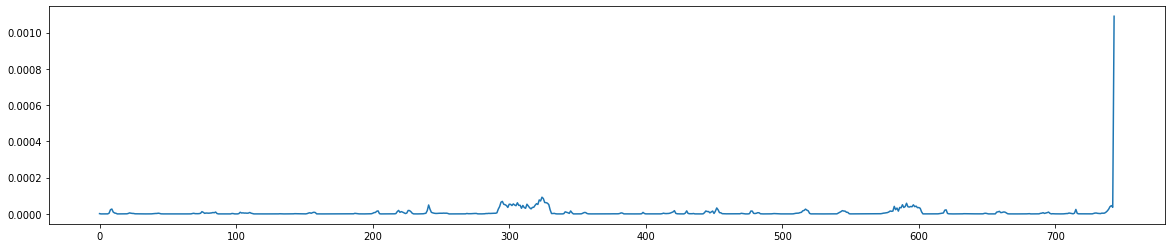

Enc_alignments: (LJ001-0085)


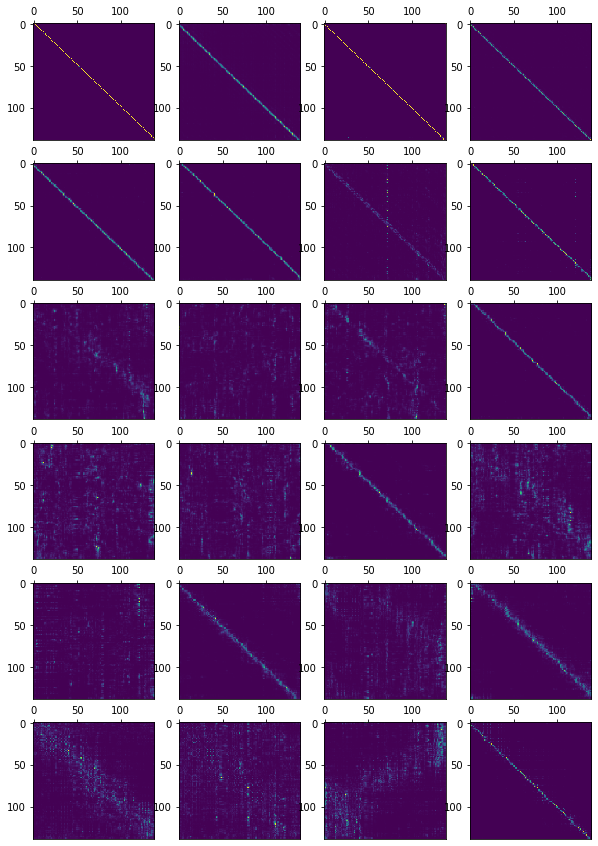

Dec_alignments: (LJ001-0085)


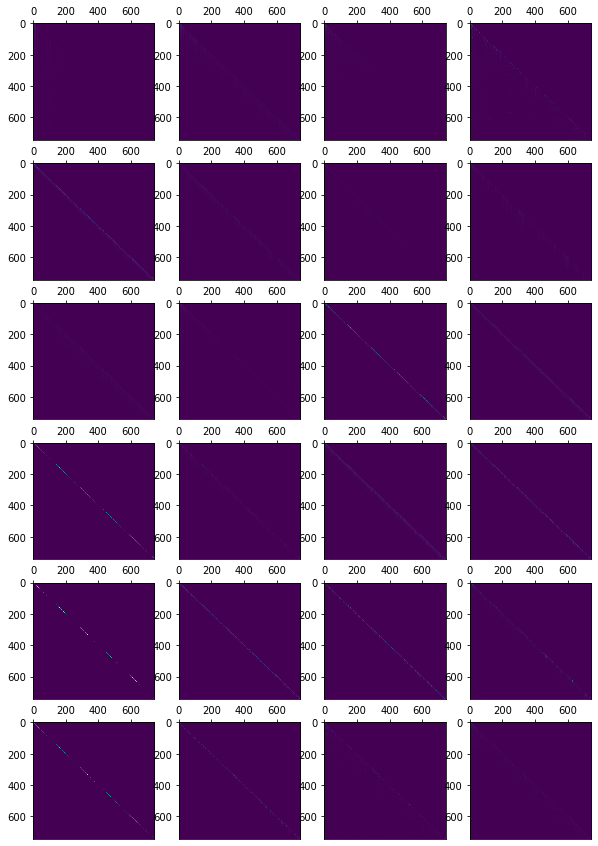

Enc_Dec_alignments: (LJ001-0085)


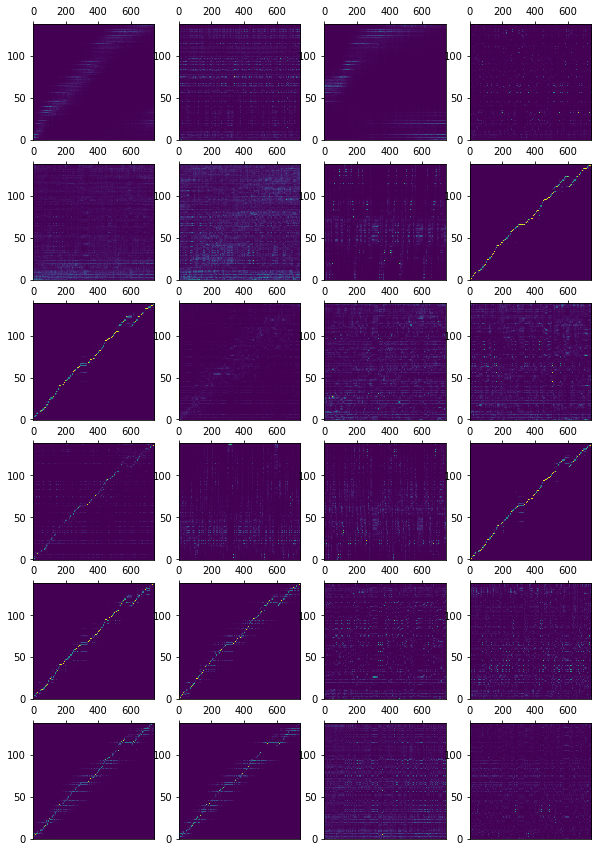

Text: (LJ002-0106)
in which latterly a copper had been fixed for the cooking of provisions sent in by charitable persons.

Melspectrogram: (LJ002-0106)


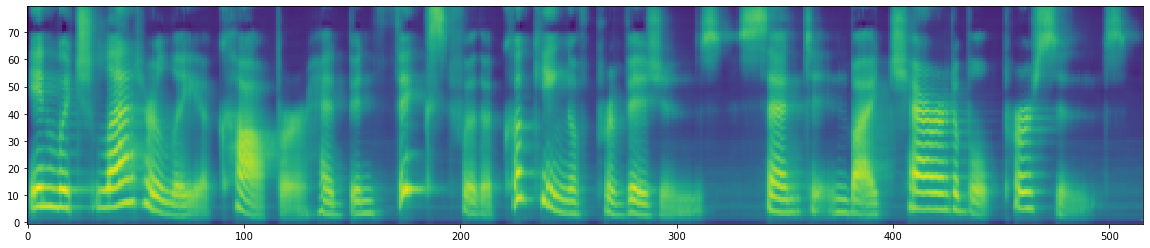

Audio: (LJ002-0106)


Stop: (LJ002-0106)


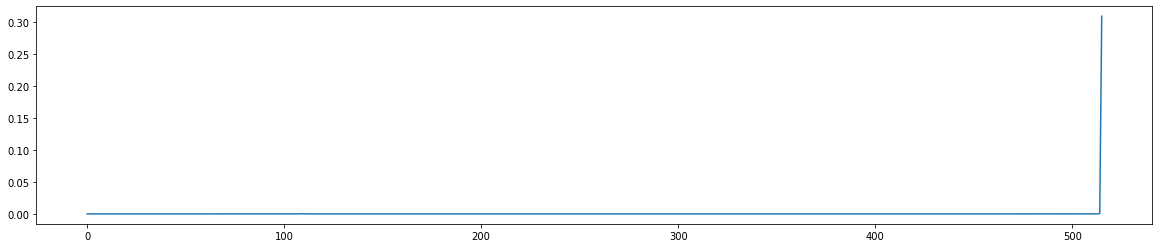

Enc_alignments: (LJ002-0106)


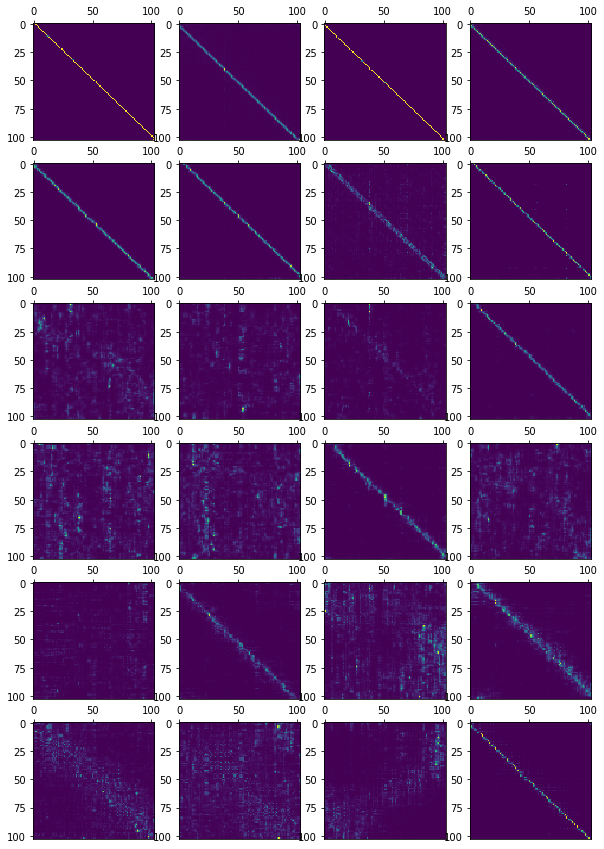

Dec_alignments: (LJ002-0106)


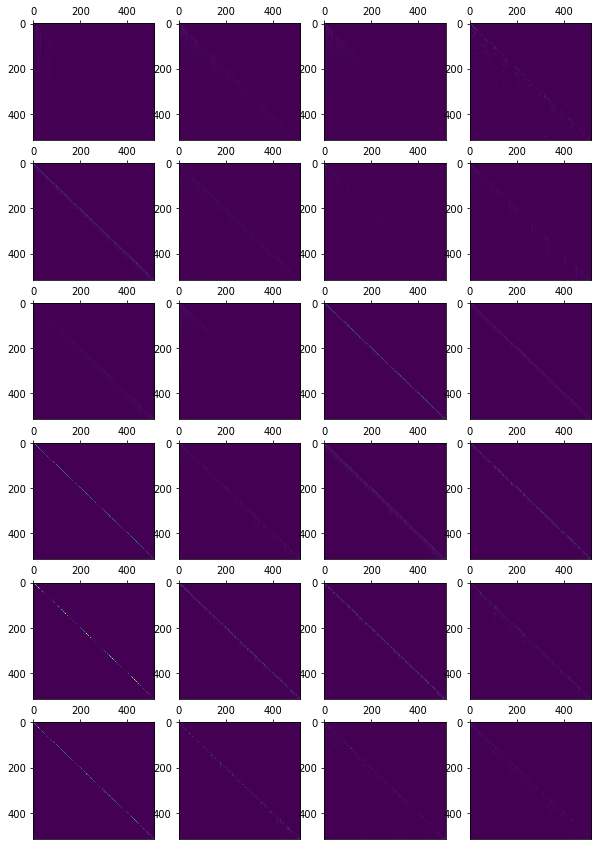

Enc_Dec_alignments: (LJ002-0106)


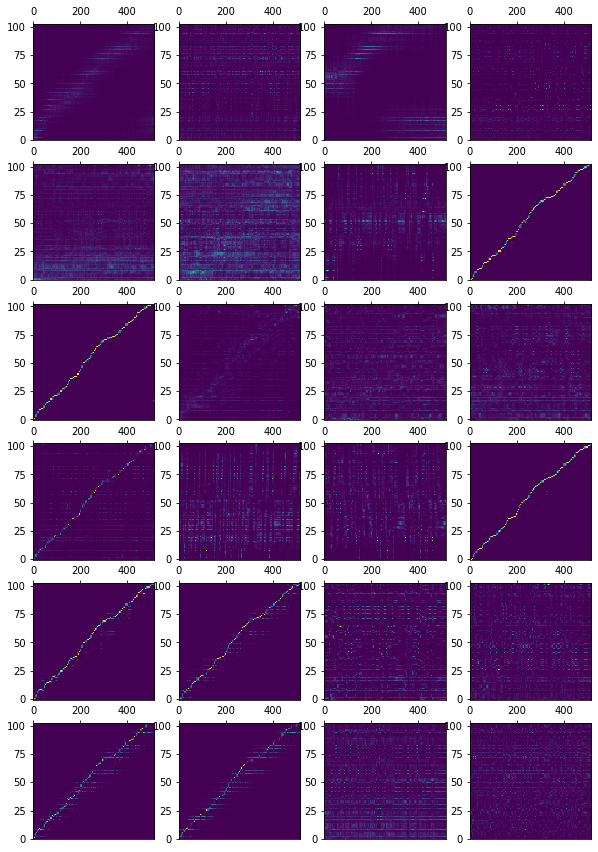

In [6]:
checkpoint_path = f"training_log/waveglow_char/checkpoint_200000"

model = Model(hparams).cuda()
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()

for i in [1, 6, 22]:
    file_name, _, text = lines[i]
    sequence = np.array(text2seq(text, data_type='char'))[None, :]
    sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()

    with torch.no_grad():
        melspec, enc_alignments, dec_alignments, enc_dec_alignments, stop = model.inference(sequence, max_len=2048)
        T=len(stop)
        melspec = melspec[:,:,:T]
        audio = waveglow.infer(melspec, sigma=0.666)
    
    
    print(f"Text: ({file_name})")
    print(text)
    print()


    print(f"Melspectrogram: ({file_name})")
    plt.figure(figsize=(20,4))
    plt.imshow(melspec[0,:,:T].detach().cpu(), origin='lower', aspect='auto')
    plt.show()


    print(f"Audio: ({file_name})")
    audio_denoised = denoiser(audio, strength=0.01)[:, 0]
    ipd.display(ipd.Audio(audio_denoised.cpu().numpy(),
                          rate=hparams.sampling_rate))
    
    print(f"Stop: ({file_name})")
    plt.figure(figsize=(20,4))
    plt.plot(stop)
    plt.show()

    
    print(f"Enc_alignments: ({file_name})")
    fig, axes = plt.subplots(6,4,figsize=(10,15))
    for layer, head in [(0,0), (0,1), (0,2), (0,3),
                        (1,0), (1,1), (1,2), (1,3),
                        (2,0), (2,1), (2,2), (2,3),
                        (3,0), (3,1), (3,2), (3,3),
                        (4,0), (4,1), (4,2), (4,3),
                        (5,0), (5,1), (5,2), (5,3)]:
        align = enc_alignments[layer][head].contiguous().detach().cpu()
        axes[layer,head].imshow(align, aspect='auto')
        axes[layer,head].xaxis.tick_top()
    plt.show()


    print(f"Dec_alignments: ({file_name})")
    fig, axes = plt.subplots(6,4,figsize=(10,15))
    for layer, head in [(0,0), (0,1), (0,2), (0,3),
                        (1,0), (1,1), (1,2), (1,3),
                        (2,0), (2,1), (2,2), (2,3),
                        (3,0), (3,1), (3,2), (3,3),
                        (4,0), (4,1), (4,2), (4,3),
                        (5,0), (5,1), (5,2), (5,3)]:
        align = dec_alignments[layer][head][:T,:T].contiguous().detach().cpu()
        axes[layer,head].imshow(align, aspect='auto')
        axes[layer,head].xaxis.tick_top()
    plt.show()


    print(f"Enc_Dec_alignments: ({file_name})")
    fig, axes = plt.subplots(6,4,figsize=(10,15))
    for layer, head in [(0,0), (0,1), (0,2), (0,3),
                        (1,0), (1,1), (1,2), (1,3),
                        (2,0), (2,1), (2,2), (2,3),
                        (3,0), (3,1), (3,2), (3,3),
                        (4,0), (4,1), (4,2), (4,3),
                        (5,0), (5,1), (5,2), (5,3)]:
        align = enc_dec_alignments[layer][head][:T].t().contiguous().detach().cpu()
        axes[layer,head].imshow(align, origin='lower', aspect='auto')
        axes[layer,head].xaxis.tick_top()
    plt.show()